<a href="https://colab.research.google.com/github/jarguetam/buscaloyaweb/blob/main/Time_Series_Forecasting_with_Machine_Learning_%5BYT%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using Machine Learning to Forecast

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from sklearn.ensemble import RandomForestRegressor


## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

In [4]:
df = pd.read_csv('VentasSemilla.csv')
df = df.set_index('DocDate')
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

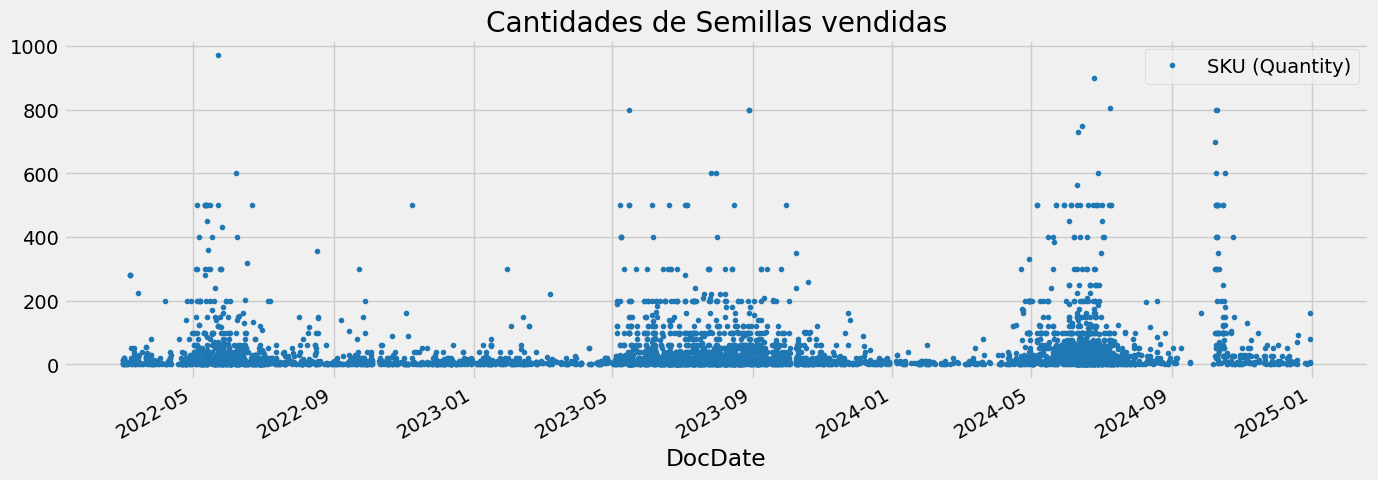

In [5]:
df['SKU (Quantity)'] = pd.to_numeric(df['(Quantity)'], errors='coerce')
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Cantidades de Semillas vendidas')
plt.show()

In [6]:
df = df.dropna(subset=['SKU (Quantity)'])

# Train / Test Split

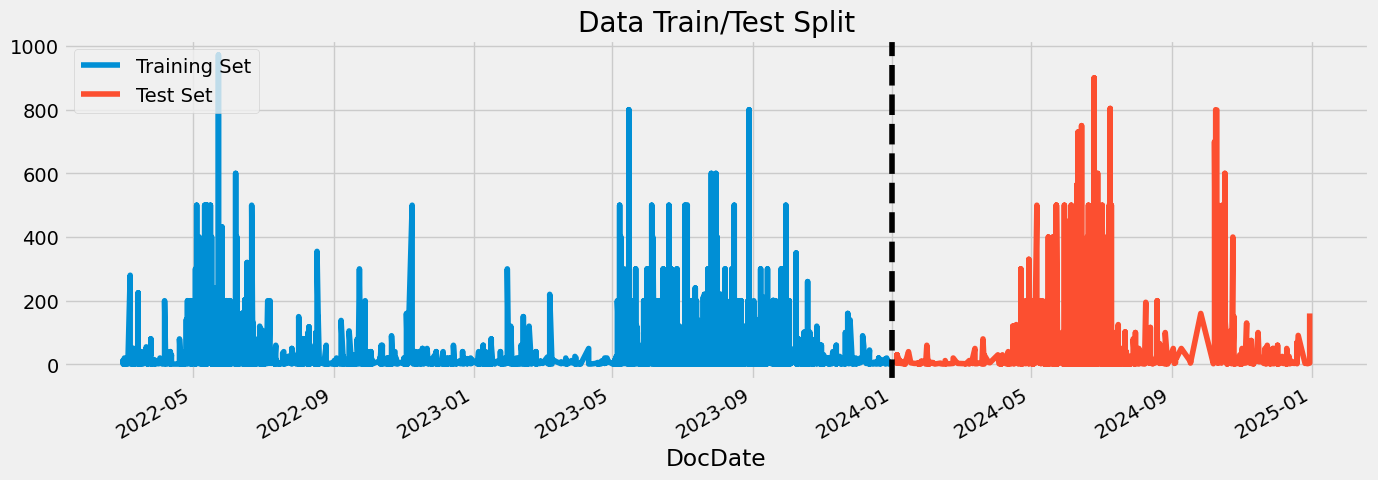

In [7]:
train = df.loc[df.index < '01-01-2024']
test = df.loc[df.index >= '01-01-2024']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2024', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

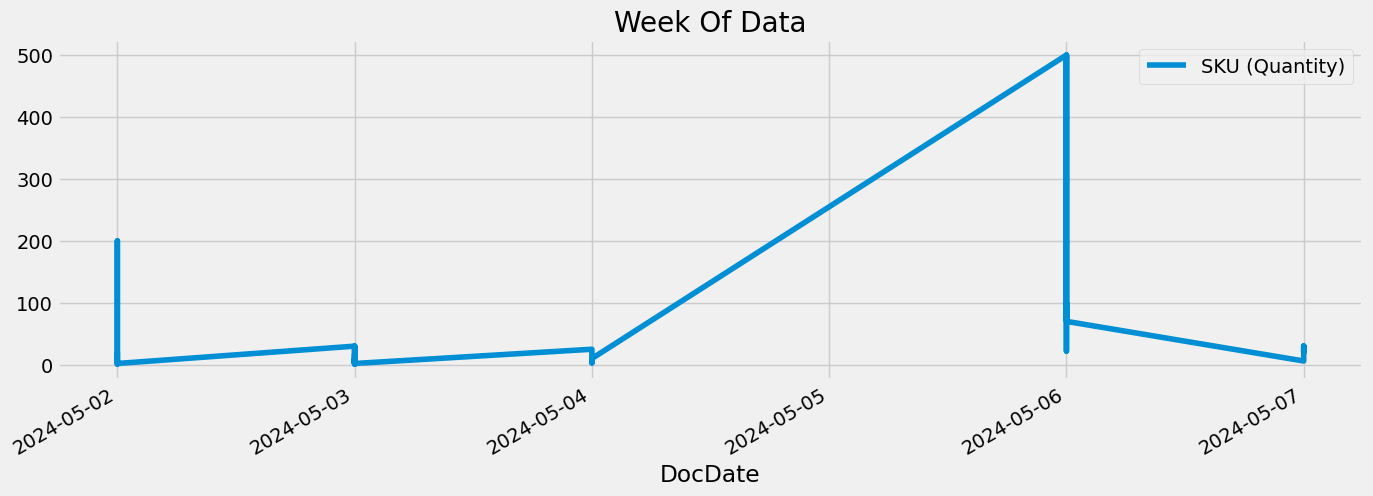

In [8]:
df.loc[(df.index > '05-01-2024') & (df.index < '05-08-2024')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [9]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

<ipython-input-10-f47b055d6bb6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=monthly_data, x='month', y='SKU (Quantity)', palette='Blues')


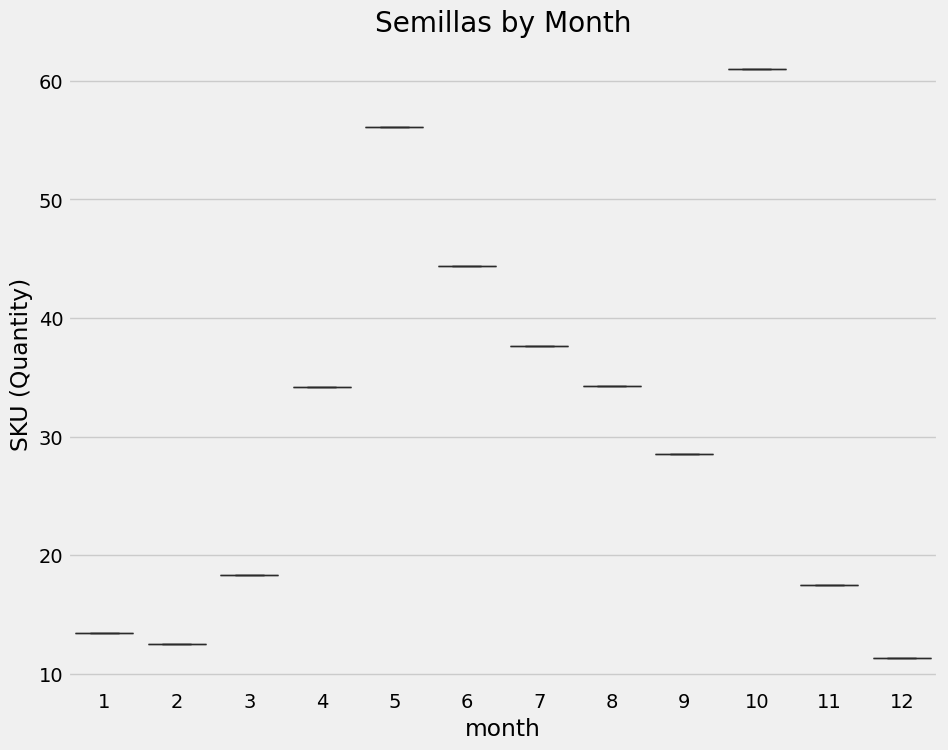

In [10]:
# Agrupar por mes y calcular el promedio de 'SKU (Quantity)'
monthly_data = df.groupby('month')['SKU (Quantity)'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=monthly_data, x='month', y='SKU (Quantity)', palette='Blues')
ax.set_title('Semillas by Month')
plt.show()

# Create our Model

In [11]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'SKU (Quantity)'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

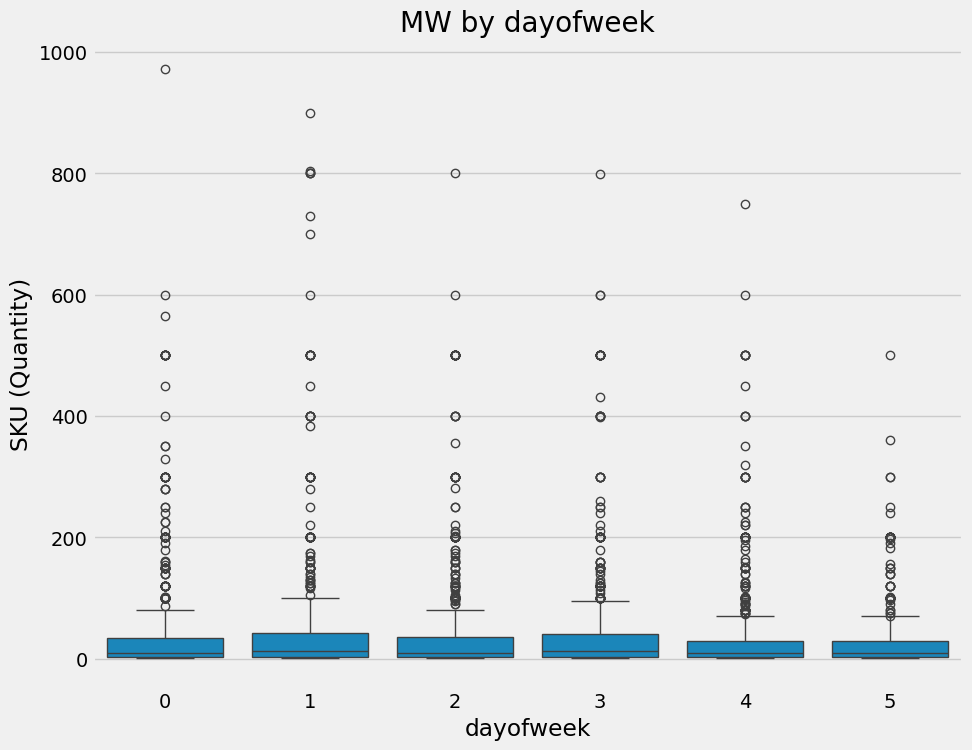

In [12]:
# Create the boxplot with the modified DataFrame
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='SKU (Quantity)')
ax.set_title('MW by dayofweek')
plt.show()

In [13]:
print("NaN en y_train:", np.isnan(y_train).any())
print("Inf en y_train:", np.isinf(y_train).any())
print("Valores extremos:", np.abs(y_train).max())

NaN en y_train: False
Inf en y_train: False
Valores extremos: 972.0


In [26]:
reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    min_samples_split=5,
    random_state=42
)

# Entrenar el modelo
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_split=5, n_estimators=300,
                      random_state=42)

In [22]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=100,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:78.22836	validation_1-rmse:115.41467
[99]	validation_0-rmse:70.82953	validation_1-rmse:107.56728


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature Importance

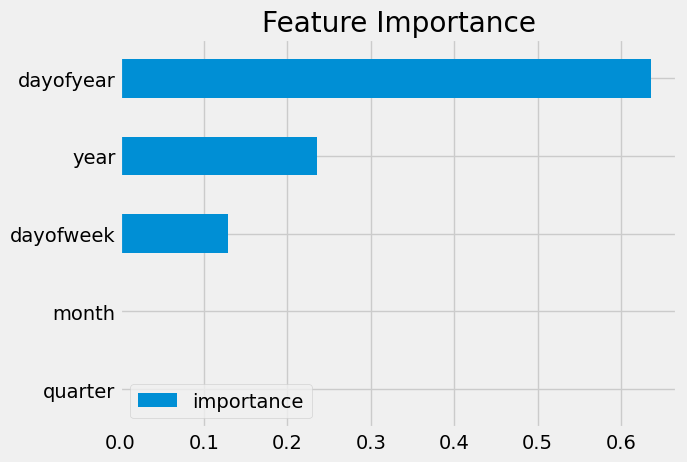

In [23]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['SKU (Quantity)']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [17]:
df.head()


,SKU,(Quantity),SKU (Quantity),dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
DocDate,,,,,,,,,,,
2022-03-01,SEM01-04-005-0005,3,3.0,1,1,3,2022,60,1,9,NaN
2022-03-01,SEM01-04-005-0001,5,5.0,1,1,3,2022,60,1,9,NaN
2022-03-01,SEM01-04-005-0008,1,1.0,1,1,3,2022,60,1,9,NaN
2022-03-01,SEM01-04-005-0007,13,13.0,1,1,3,2022,60,1,9,NaN
2022-03-01,SEM01-04-005-0002,2,2.0,1,1,3,2022,60,1,9,NaN


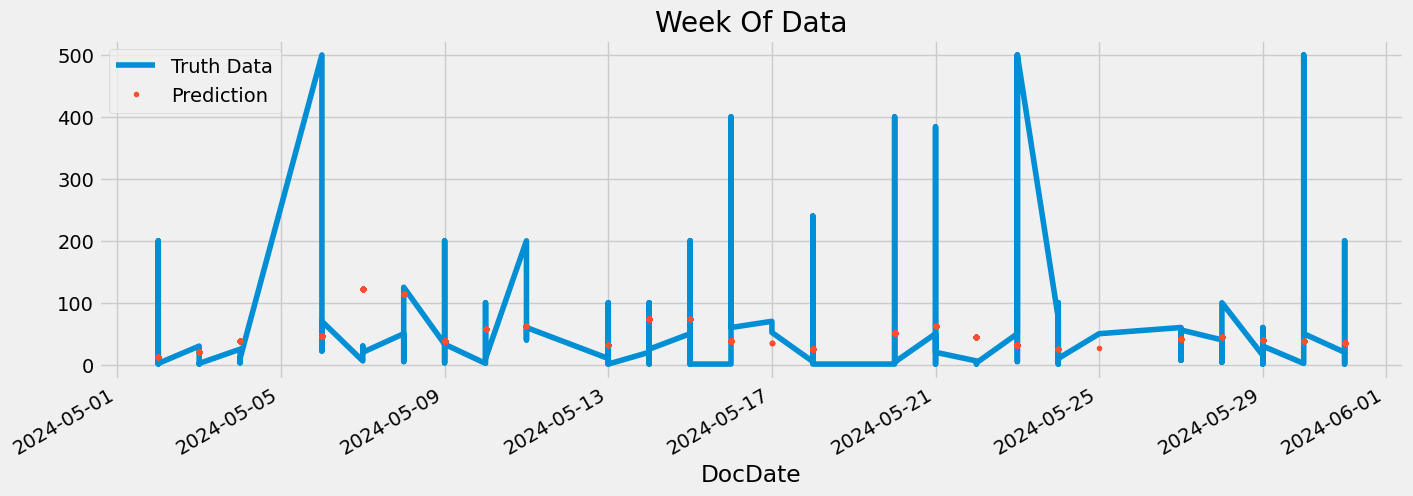

In [18]:
ax = df.loc[(df.index > '05-01-2024') & (df.index < '06-01-2024')]['SKU (Quantity)'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '05-01-2024') & (df.index < '06-01-2024')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [19]:
score = np.sqrt(mean_squared_error(test['SKU (Quantity)'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 105.33


# Calculate Error
- Look at the worst and best predicted days

In [20]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

,error
date,
2024-10-10,349.640833
2024-10-08,242.681500
2024-10-09,232.244884
2024-10-24,188.978708
2024-05-06,172.550536
2024-10-17,163.081531
2024-10-11,130.538577
2024-09-26,130.203833
2024-10-15,119.044230


# Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)

# The End